# Notebook:  Mortality in the United States 

## Introduction 
This project contains the source code to support a report on `Mortality in the United States` created by the following individuals. 

* Kunihiro Fujita 
* Qi Lu
* Segun Akinyemi
* Gowtham Anbumani


## Key Problems & Questions  
The following are the key questions that were the focus of the analysis presented in our report.

1. What are the major causes of death in the U.S? <br/><br/>
2. For the major causes of death in the U.S, what does the death distribution look like when plotted against age? (For example, histogram of 5 year age band). <br/><br/>
3. For each 5-year age band, what are the top 3 causes of death? Do they differ? <br/><br/>
4. Are the causes of death in the United States changing over time? Are there any significant increasing or decreasing trends in the prevalence of some causes? <br/><br/>
5. Given the medical transcripts of 5000 patients in the file `medicaltranscriptions.csv`, determine if any of those patients have medical conditions that are associated with the `ICD` codes of major causes of death. 
    * Design a similarity measure metric comparing `ICD` codes to medical transcripts.  
    * Calculate the similarity measure between `ICD` code descriptions and medical transcripts. 
    * Assign `ICD` codes to a medical transcript only if the similarity score is above certain threshold.
    

## Data & Library Imports
This section contains the various libraries and data files that we're used throughout our code. 

In [3]:
import re
import sys
import nltk 
import json
import copy
import warnings
import numpy as np
import pandas as pd
import texttable as tt
from numpy import genfromtxt
from tensorflow import keras
from tabulate import tabulate
import numpy.linalg as linalg
from collections import Counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from collections import defaultdict
from prettytable import PrettyTable
from tensorflow.keras import layers
import statsmodels.api as statsmodels
from gensim.models import KeyedVectors, Word2Vec
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import word_tokenize, wordpunct_tokenize

# Ensuring that output warnings are not displayed and setting some formatting options
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,}'.format

cdc_data_2005 = pd.read_csv('./mortality-data/2005_data.csv', na_values=['NA','?'])
cdc_data_2006 = pd.read_csv( './mortality-data/2006_data.csv', na_values=['NA','?'])
cdc_data_2007 = pd.read_csv( './mortality-data/2007_data.csv', na_values=['NA','?'])
cdc_data_2008 = pd.read_csv( './mortality-data/2008_data.csv', na_values=['NA','?'])
cdc_data_2009 = pd.read_csv( './mortality-data/2009_data.csv', na_values=['NA','?'])
cdc_data_2010 = pd.read_csv( './mortality-data/2010_data.csv', na_values=['NA','?'])
cdc_data_2011 = pd.read_csv( './mortality-data/2011_data.csv', na_values=['NA','?'])
cdc_data_2012 = pd.read_csv( './mortality-data/2012_data.csv', na_values=['NA','?'])
cdc_data_2013 = pd.read_csv( './mortality-data/2013_data.csv', na_values=['NA','?'])
cdc_data_2014 = pd.read_csv( './mortality-data/2014_data.csv', na_values=['NA','?'])
cdc_data_2015 = pd.read_csv( './mortality-data/2015_data.csv', na_values=['NA','?'])

# Importing ICD Codes
with open ('./mortality-data/2005_codes.json') as json_file: 
    icd_codes_2005 = json.load(json_file)   
with open ('./mortality-data/2006_codes.json') as json_file: 
    icd_codes_2006 = json.load(json_file)
with open ('./mortality-data/2007_codes.json') as json_file: 
    icd_codes_2007 = json.load(json_file)
with open ('./mortality-data/2008_codes.json') as json_file: 
    icd_codes_2008 = json.load(json_file)
with open ('./mortality-data/2009_codes.json') as json_file: 
    icd_codes_2009 = json.load(json_file)
with open ('./mortality-data/2010_codes.json') as json_file: 
    icd_codes_2010 = json.load(json_file)
with open ('./mortality-data/2011_codes.json') as json_file: 
    icd_codes_2011 = json.load(json_file)
with open ('./mortality-data/2012_codes.json') as json_file: 
    icd_codes_2012 = json.load(json_file)
with open ('./mortality-data/2013_codes.json') as json_file: 
    icd_codes_2013 = json.load(json_file)
with open ('./mortality-data/2014_codes.json') as json_file: 
    icd_codes_2014 = json.load(json_file)
with open ('./mortality-data/2015_codes.json') as json_file: 
    icd_codes_2015 = json.load(json_file)

## Function Definitions
This section defines some functions that are used repeatedly throughout our analysis.

**Function Definition: Retrieving the full name of an ICD code.**

In [4]:
    def FindFullNameFromCode(target_code, icd_codes): 
        target_code = str(target_code).zfill(3)
        for code in icd_codes: 
            if code == target_code: 
                return icd_codes[code]

**Function Definition: Finding the single most frequent cause of death in a data set**

In [5]:
    def MostFrequentCauseOfDeath(data, icd_codes): 
        most_frequent_death = str(int(data.mode()[0])).zfill(3)
        for code in icd_codes: 
            if code == most_frequent_death: 
                return icd_codes[code]

**Function Definition: Finding the top `n` causes of death in a data set** 

In [6]:
    def TopCausesOfDeath(cdc_data, icd_descriptions, n = 10):
        
        deathsByFrequency = cdc_data.value_counts()
        top_n_deaths = deathsByFrequency.head(n).rename_axis('Code').reset_index(name='Deaths')
        
        codeDescriptions = [icd_descriptions[code] for code in top_n_deaths['Code']]
        top_n_deaths["Description"] = codeDescriptions
        
        return top_n_deaths

**Function Definition: Creating a dictionary of ICD codes and their associated named descriptions.**

In [7]:
    def MapIcdToDesc(cdc_data, icd_codes): 
        codeToDescDict = {}
        
        for code in set(cdc_data): 
            zeroPaddedCode = str(code).zfill(3)
            codeToDescDict.update({
                code: icd_codes[icd] 
                for icd in icd_codes if icd == zeroPaddedCode
            }) 

        return codeToDescDict

**Function Definition: Checking the results of POS tagging. Prints out pre-tag and post-tag lists for comparison**

In [8]:
    def CheckTaggingResults(pre_tagging_list, tagged_list): 
        for index, desc in enumerate(pre_tagging_list):
            if(len(desc) != len(tagged_list[index])): 
                print("Pre-Tagging:", desc)
                print("Post-Tagging:", tagged_list[index], "\n\n")

## Major Causes of Death in the United States
This section contains the source code for the conclusions, visualizations and understandings our report presented on the major causes of death in the United States. 

In [9]:
# Creating dictionaries to hold {key, value} pairs containing {icd code, description} for each year. 
icd_desc_2005 = MapIcdToDesc(cdc_data_2005["113_cause_recode"], icd_codes_2005["113_cause_recode"])
icd_desc_2006 = MapIcdToDesc(cdc_data_2006["113_cause_recode"], icd_codes_2006["113_cause_recode"])
icd_desc_2007 = MapIcdToDesc(cdc_data_2007["113_cause_recode"], icd_codes_2007["113_cause_recode"])
icd_desc_2008 = MapIcdToDesc(cdc_data_2008["113_cause_recode"], icd_codes_2008["113_cause_recode"])
icd_desc_2009 = MapIcdToDesc(cdc_data_2009["113_cause_recode"], icd_codes_2009["113_cause_recode"])
icd_desc_2010 = MapIcdToDesc(cdc_data_2010["113_cause_recode"], icd_codes_2010["113_cause_recode"])
icd_desc_2011 = MapIcdToDesc(cdc_data_2011["113_cause_recode"], icd_codes_2011["113_cause_recode"])
icd_desc_2012 = MapIcdToDesc(cdc_data_2012["113_cause_recode"], icd_codes_2012["113_cause_recode"])
icd_desc_2013 = MapIcdToDesc(cdc_data_2013["113_cause_recode"], icd_codes_2013["113_cause_recode"])
icd_desc_2014 = MapIcdToDesc(cdc_data_2014["113_cause_recode"], icd_codes_2014["113_cause_recode"])
icd_desc_2015 = MapIcdToDesc(cdc_data_2015["113_cause_recode"], icd_codes_2015["113_cause_recode"])

In [10]:
# Finding the top 10 causes of death in the United States for each year. 
top_ten_2005 = TopCausesOfDeath(cdc_data_2005["113_cause_recode"], icd_desc_2005)
top_ten_2006 = TopCausesOfDeath(cdc_data_2006["113_cause_recode"], icd_desc_2006)
top_ten_2007 = TopCausesOfDeath(cdc_data_2007["113_cause_recode"], icd_desc_2007)
top_ten_2008 = TopCausesOfDeath(cdc_data_2008["113_cause_recode"], icd_desc_2008)
top_ten_2009 = TopCausesOfDeath(cdc_data_2009["113_cause_recode"], icd_desc_2009)
top_ten_2010 = TopCausesOfDeath(cdc_data_2010["113_cause_recode"], icd_desc_2010)
top_ten_2011 = TopCausesOfDeath(cdc_data_2011["113_cause_recode"], icd_desc_2011)
top_ten_2012 = TopCausesOfDeath(cdc_data_2012["113_cause_recode"], icd_desc_2012)
top_ten_2013 = TopCausesOfDeath(cdc_data_2013["113_cause_recode"], icd_desc_2013)
top_ten_2014 = TopCausesOfDeath(cdc_data_2014["113_cause_recode"], icd_desc_2014)
top_ten_2015 = TopCausesOfDeath(cdc_data_2015["113_cause_recode"], icd_desc_2015)

In [11]:
# Finding top deaths of all years combined and sorting by death count, highest to lowest. 
topTenAllYears = pd.concat([top_ten_2005, top_ten_2006, top_ten_2007, top_ten_2008, top_ten_2009, top_ten_2010,
                           top_ten_2011, top_ten_2012, top_ten_2013, top_ten_2014, top_ten_2015])\
                   .groupby(['Code']).sum()\
                   .sort_values(by='Deaths', ascending=False)\
                   .reset_index()

# Re-adding Description column after calculation and formatting death data with commas. 
topTenAllYears['Description'] = [icd_desc_2015[code] for code in topTenAllYears['Code']]
#topTenAllYears['Deaths'] = topTenAllYears['Deaths'].apply("{:,}".format)

# The 125s is just adding spaces to center the header. 
print('{:^125s}'.format("Top 12 Deaths in the United States from 2005 - 2015"))
topTenAllYears.style.hide_index()

                                     Top 12 Deaths in the United States from 2005 - 2015                                     


## Visualizations of Major Causes of Death 
This section contains the code we used to create visualizations for the various leading causes of death. 

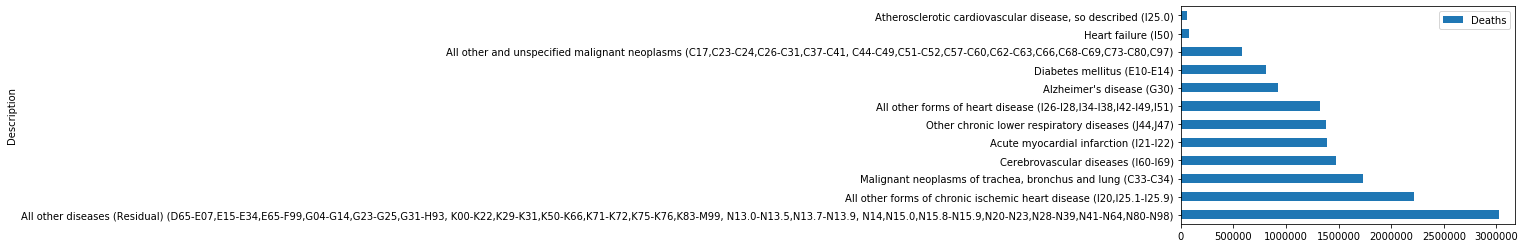

In [12]:
ax = topTenAllYears.plot.barh(x="Description", y="Deaths")
ax

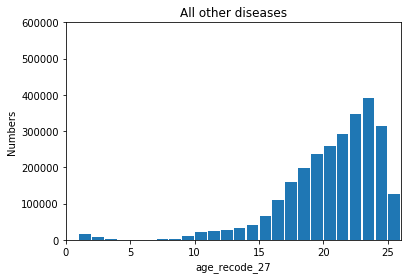

In [17]:
# Plot of All other diseases against age. 
x111 = cdc_data_2015["age_recode_27"].values
plt.title("All other diseases")
plt.xlim(0, 26)
plt.ylim(0,600000)
binblock = np.arange(1, 28, 1)
plt.hist(x111, bins = binblock, rwidth=0.9)
plt.xlabel("age_recode_27")
plt.ylabel("Numbers")
plt.show()

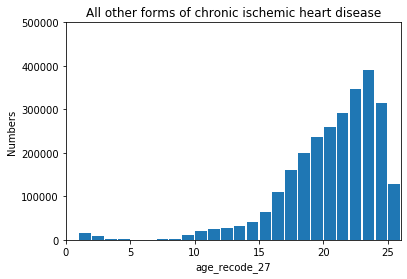

In [18]:
# Plot of Ischemic heart disease against age. 
x63 = cdc_data_2015["age_recode_27"].values
plt.title("All other forms of chronic ischemic heart disease")
plt.xlim(0, 26)
plt.ylim(0,500000)
binblock=np.arange(1, 28, 1)
plt.hist(x63, bins = binblock, rwidth=0.9)
plt.xlabel("age_recode_27")
plt.ylabel("Numbers")
plt.show()

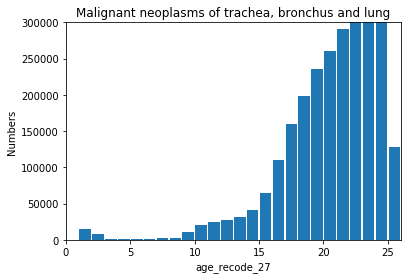

In [19]:
# Plot of Malignant neoplasms of trachea, bronchus and lung aganist age. 
x27 = cdc_data_2015["age_recode_27"].values
plt.title("Malignant neoplasms of trachea, bronchus and lung")
plt.xlim(0, 26)
plt.ylim(0,300000)
binblock=np.arange(1, 28, 1)
plt.hist(x27 ,bins = binblock, rwidth=0.9)
plt.xlabel("age_recode_27")
plt.ylabel("Numbers")
plt.show()

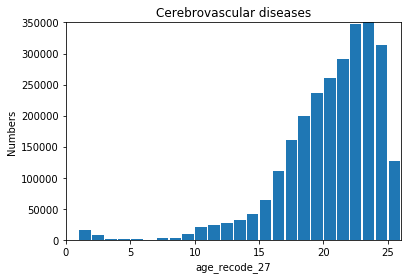

In [20]:
# Plot of Cerebrovascular diseases aganist age. 
x70 = cdc_data_2015["age_recode_27"].values
plt.title("Cerebrovascular diseases")
plt.xlim(0, 26)
plt.ylim(0,350000)
binblock=np.arange(1, 28, 1)
plt.hist(x70 ,bins = binblock, rwidth=0.9)
plt.xlabel("age_recode_27")
plt.ylabel("Numbers")
plt.show()

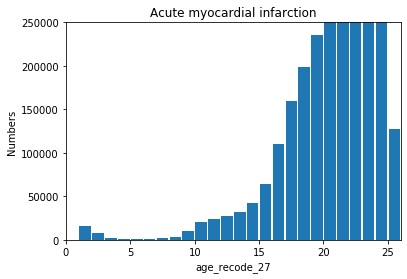

In [21]:
# Plot of Acute myocardial infarction againist age. 
x59 =cdc_data_2015["age_recode_27"].values
plt.title("Acute myocardial infarction")
plt.xlim(0, 26)
plt.ylim(0,250000)
binblock=np.arange(1, 28, 1)
plt.hist(x59 ,bins = binblock, rwidth=0.9)
plt.xlabel("age_recode_27")
plt.ylabel("Numbers")
plt.show()

## Regression & Relational Analysis
Please see the file titled `FinalProject-GroupA-ModelCode.html` for the source code that was used to generated the models used throughout our analysis and report. 

## Medical Transcripts & ICD Codes
This section contains our code for completing the tasks assigned in question 5. Here we take the medical transcripts of 5000 patients and determine the likelihood of those patients having a medical condition associated with a top 12 cause of death in the U.S (taking into consideration the top 12 from 2005 - 2015, as calculated earlier). 

In [323]:
# Importing Medical Transcript Data and a pre-made binary file for vectorizing our data. 
medical_data = pd.read_csv('./data-from-canvas/medicaltranscriptions.csv', sep=',', header=0)
pub_med_model = KeyedVectors.load_word2vec_format('./data-from-canvas/PubMed-and-PMC-w2v.bin', binary=True)
stop_words = set(stopwords.words('english'))

In [357]:
# Ignore this. Used to check that we aren't losing data
    def check(): 
        print("Tagged Desriptions", len(medical_desc_tagged))
        print("Tokenixed Desriptions", len(medical_desc_tokenized))
        print("Long Desc", len(long_descriptions))
        print("766 Long Desc", long_descriptions[766])
        print("766 Tokenized", medical_desc_tokenized[766])        
        print("766 Tagged", medical_desc_tagged[766])

In [399]:
# Creating a list of lists, where each internal list is a tokenized description, one for each patient description in the 
# medicaltranscripts.csv file. 

patientId = 0
long_descriptions = {}
medical_desc_tokenized = []

for desc in medical_data['description']:
    if(desc.isspace()): 
        continue
    long_descriptions[patientId] = desc
    token_desc = word_tokenize(desc) 
    token_desc = [word for word in token_desc if word]
    token_desc = [word.lower() for word in token_desc] 
    token_desc = [word.lower() for word in token_desc if not word in stop_words] 
    token_desc = [word.lower() for word in token_desc if word.isalpha()]
    medical_desc_tokenized.append(token_desc)
    patientId += 1

In [400]:
# Removing duplicates from each individual description, for example "heart pain heart" becomes "heart pain". 
medical_desc_tokenized = [list(set(desc_list)) for desc_list in medical_desc_tokenized]

In [401]:
# Part of Speech tagging for each word in each patient description. We keep nouns, verbs and adjectives. We tried
# this with only nouns and found that adding verbs and adjectives gives us better cosine similarity scores. 
accpetable_tags = ['NN', 'NNP', 'NNS', 'NNPS', 'JJ', 'JJR', 'JJS', 'VBG']
medical_desc_tagged = copy.deepcopy(medical_desc_tokenized)

for index, desc_list in enumerate(medical_desc_tagged): 
    token_list = nltk.pos_tag(desc_list)
    for word, pos in token_list:
        if (pos not in accpetable_tags):
            desc_list.remove(word)
    if(len(desc_list) == 0): 
        del medical_desc_tagged[index]
        del long_descriptions[index]

In [404]:
# All possible POS tags returned by this function. 
# nltk.help.upenn_tagset()
#pd.set_option('display.max_colwidth', -1)

# Using a function to check the results of POS tagging. Prints each description before & after tagging.
CheckTaggingResults(medical_desc_tokenized, medical_desc_tagged)

Pre-Tagging: ['years', 'anastomosis', 'female', 'many', 'diets', 'eea', 'gastric', 'unsuccessful', 'antecolic', 'bypass', 'tried', 'obesity', 'laparoscopic', 'overweight', 'morbid', 'different', 'antegastric']
Post-Tagging: ['years', 'female', 'many', 'diets', 'gastric', 'unsuccessful', 'antecolic', 'bypass', 'obesity', 'laparoscopic', 'overweight', 'morbid', 'different', 'antegastric'] 


Pre-Tagging: ['revision', 'breast', 'soft', 'fullness', 'supraumbilical', 'tissue', 'lateral', 'abdomen', 'flank', 'excision', 'reconstruction', 'liposuction', 'right']
Post-Tagging: ['revision', 'breast', 'soft', 'supraumbilical', 'tissue', 'lateral', 'abdomen', 'flank', 'excision', 'reconstruction', 'liposuction', 'right'] 


Pre-Tagging: ['mild', 'pressures', 'biatrial', 'tricuspid', 'heart', 'enlargement', 'normal', 'increase', 'ventricle', 'left', 'right', 'regurgitation', 'moderate']
Post-Tagging: ['mild', 'pressures', 'biatrial', 'tricuspid', 'heart', 'enlargement', 'normal', 'increase', 'vent

Post-Tagging: ['appendectomy', 'appendicitis', 'pressure', 'versastep', 'maximum', 'insufflation', 'port', 'umbilicus', 'laparoscopic', 'mmhg'] 


Pre-Tagging: ['post', 'band', 'lap', 'placement', 'patient', 'status']
Post-Tagging: ['post', 'band', 'placement', 'patient', 'status'] 


Pre-Tagging: ['bone', 'fusion', 'posterior', 'songer', 'lumbar', 'decompressive', 'cervical', 'left', 'wire', 'laminectomy', 'foraminotomy', 'neural', 'iliac', 'right', 'graft']
Post-Tagging: ['bone', 'fusion', 'songer', 'lumbar', 'decompressive', 'cervical', 'wire', 'laminectomy', 'foraminotomy', 'neural', 'iliac', 'right', 'graft'] 


Pre-Tagging: ['retrieval', 'retained', 'insertion', 'new', 'lumbar', 'attempted', 'microdissection', 'drain', 'laminotomy', 'fluoroscopy', 'body', 'spinal', 'external', 'foreign', 'catheter']
Post-Tagging: ['retrieval', 'insertion', 'new', 'lumbar', 'microdissection', 'drain', 'laminotomy', 'fluoroscopy', 'body', 'spinal', 'external', 'foreign', 'catheter'] 


Pre-Tagging:

Post-Tagging: ['cell', 'flap', 'skin', 'conjunctival', 'preauricular', 'dorsal', 'large', 'upper', 'lower', 'basal', 'excision', 'carcinoma', 'right', 'graft'] 


Pre-Tagging: ['positive', 'biopsy', 'tip', 'nasal', 'basal', 'excision', 'previous', 'carcinoma']
Post-Tagging: ['positive', 'biopsy', 'tip', 'nasal', 'excision', 'previous', 'carcinoma'] 


Pre-Tagging: ['creation', 'fistula', 'brachiobasilic', 'stage', 'autologous', 'arteriovenous', 'first', 'right']
Post-Tagging: ['creation', 'brachiobasilic', 'stage', 'autologous', 'arteriovenous', 'right'] 


Pre-Tagging: ['mass', 'dissection', 'drainage', 'recurrent', 'rule', 'axillary', 'hodgkin', 'excision', 'left', 'disease', 'masses', 'incision', 'right', 'bilateral']
Post-Tagging: ['mass', 'dissection', 'drainage', 'recurrent', 'rule', 'axillary', 'hodgkin', 'excision', 'disease', 'masses', 'incision', 'bilateral'] 


Pre-Tagging: ['fistula', 'cephalic', 'vein', 'left', 'artery', 'arteriovenous', 'forearm', 'radial']
Post-Tagging: 

Pre-Tagging: ['clinical', 'changes', 'prior', 'hemorrhage', 'immediately', 'acute', 'mri', 'occurred', 'scan', 'intracerebral']
Post-Tagging: ['clinical', 'changes', 'acute', 'mri', 'scan', 'intracerebral'] 


Pre-Tagging: ['exposure', 'diminishing', 'target', 'risk', 'order', 'planned', 'therapy', 'structures', 'uninvolved', 'adjacent', 'normal', 'radiation', 'patient', 'degree', 'undergoing', 'simulation', 'adequately']
Post-Tagging: ['exposure', 'diminishing', 'target', 'risk', 'order', 'therapy', 'uninvolved', 'adjacent', 'normal', 'radiation', 'patient', 'degree', 'undergoing', 'simulation'] 


Pre-Tagging: ['adderall', 'well', 'hyperactivity', 'male', 'disorder', 'attention', 'fairly', 'deficit']
Post-Tagging: ['hyperactivity', 'male', 'disorder', 'attention', 'deficit'] 


Pre-Tagging: ['involved', 'following', 'mostly', 'psychosocial', 'donor', 'evaluation', 'questions']
Post-Tagging: ['following', 'psychosocial', 'donor', 'evaluation', 'questions'] 


Pre-Tagging: ['answers', 

Post-Tagging: ['toe', 'scarf', 'foot', 'internal', 'arthroplasty', 'fixation', 'second', 'bunion', 'type', 'metatarsal', 'left', 'bunionectomy', 'hammertoe', 'osteotomy'] 


Pre-Tagging: ['toe', 'foot', 'internal', 'distal', 'fixation', 'screw', 'metatarsal', 'wire', 'bunionectomy', 'akin', 'right', 'first', 'osteotomy']
Post-Tagging: ['toe', 'foot', 'internal', 'distal', 'fixation', 'metatarsal', 'wire', 'bunionectomy', 'akin', 'right'] 


Pre-Tagging: ['injection', 'stenosing', 'transverse', 'ligament', 'release', 'tenosynovitis', 'finger', 'left', 'endoscopic', 'middle', 'carpal', 'right', 'steroid']
Post-Tagging: ['injection', 'stenosing', 'transverse', 'ligament', 'release', 'tenosynovitis', 'finger', 'endoscopic', 'middle', 'carpal', 'right', 'steroid'] 


Pre-Tagging: ['foot', 'internal', 'fixation', 'bunion', 'base', 'type', 'metatarsal', 'wedge', 'screw', 'left', 'wire', 'bunionectomy', 'akin', 'first', 'osteotomy']
Post-Tagging: ['foot', 'internal', 'fixation', 'bunion', 'bas

Pre-Tagging: ['leg', 'toxin', 'casts', 'hamstrings', 'obturator', 'injection', 'short', 'rectus', 'femoris', 'neurolysis', 'application', 'fiberglass', 'botulinum', 'nerves', 'muscles', 'bilateral', 'phenol', 'gastrocnemius', 'medial', 'soleus']
Post-Tagging: ['leg', 'toxin', 'hamstrings', 'obturator', 'injection', 'short', 'rectus', 'femoris', 'neurolysis', 'application', 'fiberglass', 'botulinum', 'nerves', 'bilateral', 'phenol', 'gastrocnemius', 'medial', 'soleus'] 


Pre-Tagging: ['exploration', 'pituitary', 'exposure', 'within', 'adenoma', 'sphenoid', 'removal', 'tissue', 'sinus', 'transsphenoidal', 'endoscopic', 'excision', 'radical']
Post-Tagging: ['exploration', 'pituitary', 'exposure', 'adenoma', 'sphenoid', 'removal', 'tissue', 'sinus', 'transsphenoidal', 'endoscopic', 'excision', 'radical'] 


Pre-Tagging: ['removed', 'therapy', 'female', 'following', 'referred', 'post', 'tumor', 'weakness', 'removal', 'complications', 'patient', 'physical', 'status', 'related', 'brain']
Pos

Pre-Tagging: ['leg', 'peripheral', 'foot', 'status', 'chronic', 'recent', 'nephropathy', 'stage', 'post', 'swelling', 'diabetic', 'history', 'medical', 'right', 'pta', 'female', 'vascular', 'disease', 'left', 'kidney', 'hand', 'hospital', 'past', 'diabetes', 'admitted', 'mellitus']
Post-Tagging: ['leg', 'peripheral', 'foot', 'status', 'chronic', 'recent', 'nephropathy', 'stage', 'post', 'swelling', 'diabetic', 'history', 'medical', 'right', 'pta', 'female', 'vascular', 'disease', 'kidney', 'hand', 'hospital', 'past', 'diabetes', 'mellitus'] 


Pre-Tagging: ['stenosis', 'ii', 'female', 'heart', 'past', 'hypertension', 'type', 'diabetes', 'disease', 'atherosclerotic', 'carotid', 'history']
Post-Tagging: ['stenosis', 'ii', 'female', 'heart', 'hypertension', 'type', 'disease', 'atherosclerotic', 'carotid', 'history'] 


Pre-Tagging: ['medifast', 'mild', 'wheezing', 'nights', 'edema', 'progressive', 'fatigue', 'increased', 'past', 'peripheral', 'breath', 'dyspnea', 'orthopnea', 'patient', '

Pre-Tagging: ['struggled', 'prior', 'hypoxia', 'pneumonia', 'weakness', 'suspected', 'cough', 'mild', 'week', 'arthritis', 'admission', 'insufficiency', 'independent', 'fevers', 'atypical', 'old', 'rheumatoid', 'adrenal', 'chills']
Post-Tagging: ['prior', 'hypoxia', 'pneumonia', 'weakness', 'cough', 'mild', 'week', 'arthritis', 'admission', 'insufficiency', 'independent', 'fevers', 'atypical', 'old', 'rheumatoid', 'adrenal', 'chills'] 


Pre-Tagging: ['suggested', 'ct', 'scan', 'suspected', 'resolving', 'ear', 'pain', 'severe', 'right', 'male', 'media', 'er', 'acute', 'mastoiditis', 'patient', 'child', 'admitted', 'otitis', 'ruled']
Post-Tagging: ['ct', 'scan', 'resolving', 'ear', 'pain', 'severe', 'male', 'media', 'acute', 'mastoiditis', 'patient', 'child', 'otitis'] 


Pre-Tagging: ['mass', 'cervix', 'summary', 'discharge', 'presenting', 'large', 'patient', 'aborted']
Post-Tagging: ['mass', 'cervix', 'summary', 'discharge', 'presenting', 'large', 'patient'] 


Pre-Tagging: ['weight',


Pre-Tagging: ['dietary', 'diagnosed', 'female', 'type', 'diabetes', 'consult']
Post-Tagging: ['dietary', 'female', 'type', 'consult'] 


Pre-Tagging: ['assistant', 'sheets', 'diary', 'brought', 'patient', 'food']
Post-Tagging: ['assistant', 'sheets', 'diary', 'patient', 'food'] 


Pre-Tagging: ['weight', 'pattern', 'others', 'assistance', 'due', 'items', 'loss', 'physical', 'activity', 'balanced', 'diary', 'patient', 'picking', 'keeping', 'food', 'diet', 'successful', 'getting']
Post-Tagging: ['weight', 'pattern', 'others', 'due', 'items', 'loss', 'physical', 'activity', 'diary', 'patient', 'picking', 'keeping', 'food', 'diet', 'successful', 'getting'] 


Pre-Tagging: ['diabetes', 'consultation', 'pregnancy', 'dietary']
Post-Tagging: ['diabetes', 'pregnancy', 'dietary'] 


Pre-Tagging: ['decreased', 'extraction', 'eye', 'vision', 'past', 'lens', 'includes', 'eyes', 'left', 'cataract', 'ocular', 'implants', 'history']
Post-Tagging: ['extraction', 'eye', 'vision', 'lens', 'eyes', 'catar

Post-Tagging: ['chest', 'neck', 'injuries', 'sharp', 'cutting', 'involving', 'abdomen', 'multiple', 'force', 'wounds'] 


Pre-Tagging: ['weight', 'via', 'opposed', 'elective', 'loss', 'bypass', 'gastric', 'surgical', 'evaluation']
Post-Tagging: ['weight', 'opposed', 'elective', 'loss', 'bypass', 'gastric', 'surgical', 'evaluation'] 


Pre-Tagging: ['anoxic', 'encephalopathy', 'death', 'cause']
Post-Tagging: ['encephalopathy', 'death', 'cause'] 


Pre-Tagging: ['strangulation', 'injuries', 'autopsy', 'craniocerebral', 'ligature']
Post-Tagging: ['strangulation', 'injuries', 'craniocerebral', 'ligature'] 


Pre-Tagging: ['environmental', 'chronic', 'inhalant', 'probable', 'glossitis', 'allergies', 'xerostomia', 'food', 'history', 'asthma']
Post-Tagging: ['environmental', 'chronic', 'inhalant', 'probable', 'glossitis', 'allergies', 'food', 'history', 'asthma'] 


Pre-Tagging: ['congestion', 'ago', 'three', 'two', 'eye', 'facial', 'discomfort', 'pain', 'drip', 'nasal', 'symptoms', 'patient'

In [403]:
# Tokenizing and cleaning up the ICD code descriptions. We don't want the uneccesary stuff in there. . 
icd_desc_tokenized = []
for desc in topTenAllYears['Description']: 
    token_desc = word_tokenize(desc) 
    token_desc = [word for word in token_desc if word]
    token_desc = [word for word in token_desc if word.isalpha()]
    icd_desc_tokenized.append(token_desc)

icd_desc_tokenized

[['All', 'other', 'diseases', 'Residual'],
 ['All', 'other', 'forms', 'of', 'chronic', 'ischemic', 'heart', 'disease'],
 ['Malignant', 'neoplasms', 'of', 'trachea', 'bronchus', 'and', 'lung'],
 ['Cerebrovascular', 'diseases'],
 ['Acute', 'myocardial', 'infarction'],
 ['Other', 'chronic', 'lower', 'respiratory', 'diseases'],
 ['All', 'other', 'forms', 'of', 'heart', 'disease'],
 ['Alzheimer', 'disease'],
 ['Diabetes', 'mellitus'],
 ['All', 'other', 'and', 'unspecified', 'malignant', 'neoplasms'],
 ['Heart', 'failure'],
 ['Atherosclerotic', 'cardiovascular', 'disease', 'so', 'described']]

In [405]:
# Creating a new list of lists, where each internal list is a patient visit description with ONLY words that can be 
# converted to a vector. 
medical_desc_modeled = []
for desc in medical_desc_tagged: 
    desc_list = [word for word in desc if word in pub_med_model]
    medical_desc_modeled.append(desc_list)

In [440]:
# Calculating a similarity score between the ICD code description and the description of each patients medical visit. We
# use a cutoff similarity score of 0.40, or 40%. Meaning, the cosine similarity between the patients visit description and
# an ICD code description must be 40% or higher for us to consider it in our final output. This is our similarity measure
# metric 

patientId = 0
similarities_and_desc = []

for desc in medical_desc_modeled: 
    patient_desc_sentence = ' '.join(word for word in desc)
    for code_desc in icd_desc_tokenized:
        cosine_sim = pub_med_model.n_similarity(desc, code_desc)
        if(cosine_sim < 0.4): 
            continue
        icd_desc_sentence = ' '.join(word for word in code_desc)
        data = (patientId, patient_desc_sentence, icd_desc_sentence, cosine_sim)
        similarities_and_desc.append(data)
    patientId += 1

In [441]:
# Creating a final output data frame, sorting by highest similarity scores to lowest, and converting from a pos tagged
# list description back to the long form sentence descriptions, for display purposes. 

final_patient_data = pd.DataFrame(similarities_and_desc, columns = ["Patient Id", 
                                                                    "Visit Description", 
                                                                    "ICD Code Description", 
                                                                    "Cosine Similarity"])

# Converting from the tokenized description back to the long form description.
for index, row in final_patient_data.iterrows(): 
    final_patient_data.loc[index, "Visit Description"] = long_descriptions[row["Patient Id"]]

final_patient_data = final_patient_data.sort_values("Cosine Similarity", ascending=False)
final_patient_data["Cosine Similarity"] = ["{0:.0%}".format(sim) for sim in final_patient_data["Cosine Similarity"]]
pd.set_option('display.max_rows', 45000)
pd.set_option('display.max_colwidth', -1)

# Length of 3864 with 0.40 as the cutoff similarity score. 
final_patient_data.style.hide_index()